In [1]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def evaluate(col, score_df, answer=False):
    if answer:
        res = "answer"
    else:
        res = "result"
    def f1(row):
        scores = scorer.score(row['gold_answer'], row[f'{col}_{res}'])
        return scores['rougeL'].fmeasure
    def rc(row):
        scores = scorer.score(row['gold_answer'], row[f'{col}_{res}'])
        return scores['rougeL'].recall
    def pre(row):
        scores = scorer.score(row['gold_answer'], row[f'{col}_{res}'])
        return scores['rougeL'].precision
    score_df[f'{col}_f1'] = score_df.apply(f1, axis=1)
    score_df[f'{col}_rc'] = score_df.apply(rc, axis=1)
    score_df[f'{col}_pre'] = score_df.apply(pre, axis=1)

Long memory score

In [2]:
import pandas as pd

number = 500
answer_df = pd.read_json("MSC_eval.json", lines=True)
# answer_df = pd.read_json("MSC_score_v1.json", lines=True)
score_df = answer_df[:number]

In [3]:
answer=False
evaluate('long_mem', score_df, answer=answer)
evaluate('long_mem_recall', score_df, answer=answer)
long_mem_means = score_df[['long_mem_f1', 'long_mem_rc', 'long_mem_pre']].mean()
long_mem_recall_means = score_df[['long_mem_recall_f1', 'long_mem_recall_rc', 'long_mem_recall_pre']].mean()
print(long_mem_means)
print(long_mem_recall_means)

long_mem_f1     0.019428
long_mem_rc     0.712716
long_mem_pre    0.009954
dtype: float64
long_mem_recall_f1     0.039456
long_mem_recall_rc     0.696054
long_mem_recall_pre    0.020716
dtype: float64


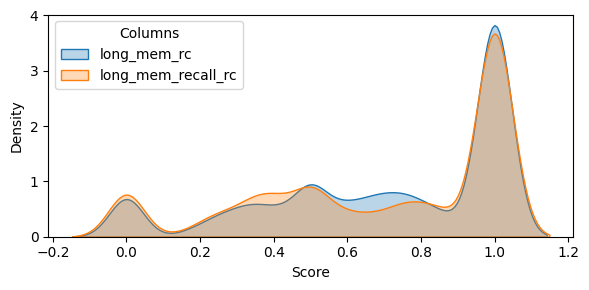

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

columns = ['long_mem_rc', 'long_mem_recall_rc']

plt.figure(figsize=(6, 3))

for i, column in enumerate(columns):
    data = score_df[column]
    sns.kdeplot(data, label=column, fill=True, alpha=0.3, bw_adjust=0.5)
    
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend(title="Columns")
plt.tight_layout()
plt.show()


In [5]:
score_df[score_df['long_mem_recall_rc']<=0.5].index

Index([  1,   9,  10,  14,  15,  18,  22,  23,  24,  27,
       ...
       469, 470, 474, 487, 489, 490, 491, 495, 497, 499],
      dtype='int64', length=176)

In [6]:
score_df[score_df['long_mem_recall_rc']<score_df['long_mem_rc']].index

Index([  1,   9,  23,  34,  37,  44,  46,  48,  55,  59,
       ...
       448, 456, 459, 462, 464, 465, 474, 489, 491, 493],
      dtype='int64', length=105)

In [29]:
score_df[score_df['long_mem_recall_rc']>score_df['long_mem_rc']].index

Index([  4,   5,  12,  13,  14,  15,  26,  31,  45,  47,  54,  61,  72,  75,
        82,  84,  85,  88, 102, 105, 110, 119, 121, 124, 140, 162, 171, 181,
       189, 192, 196, 208, 227, 235, 236, 237, 238, 240, 241, 242, 243, 255,
       261, 268, 274, 275, 280, 294, 300, 302, 307, 311, 312, 318, 322, 348,
       357, 363, 367, 371, 374, 403, 405, 406, 414, 418, 421, 422, 423, 424,
       425, 426, 430, 431, 436, 438, 447, 451, 453, 463, 475, 482, 495, 498],
      dtype='int64')

In [37]:
index = 498
eval(score_df['long_mem_recall_result'][index])

{'search_times': 1,
 'used_keywords': ['Hey, remember that time we talked about your family? How many kids do you have again?'],
 'searched_memory': [{'text': "Conversations focus on family, revealing the user's growing family and the assistant's desire for a pet, particularly a husky.",
   'time': '2024/11/01 12:07'}],
 'thought': "The retrieved information from the conversations directly addresses the user's query about the assistant's family.",
 'evidence': [{'text': 'user:Three and one on the way. The dog is like a child too.',
   'time': '2024/11/01 12:07'}]}

In [11]:
score_df.to_json("MSC_score_0211.json", orient='records', lines=True)

Short memory score

In [41]:
import pandas as pd

number = 500
answer_df = pd.read_json("s_MSC_eval.json", lines=True)
# answer_df = pd.read_json("s_MSC_score_v1.json", lines=True)
score_df = answer_df[:number]
evaluate('short_mem', score_df)

In [7]:
short_mem_means = score_df[['short_mem_f1', 'short_mem_rc', 'short_mem_pre']].mean()
print(short_mem_means)

short_mem_f1     0.031469
short_mem_rc     0.826127
short_mem_pre    0.016256
dtype: float64


In [77]:
score_df.to_json("s_MSC_score.json", orient='records', lines=True)

LLM judge

In [12]:
from dotenv import load_dotenv
from openai import OpenAI
import os

load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def llm_create(prompt):
        messages = [{"role": "user", "content": prompt}]
        completion = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=messages,
            temperature=0
        )
        return completion.choices[0].message.content

judge_prompt = """Your task is to label an answer to a question as ‘CORRECT’ or ‘WRONG’.

You will be given the following data:

A question (posed by one user to another user).
A ‘gold’ (ground truth) answer.
A generated answer, which you will score as CORRECT/WRONG.
The point of the question is to ask about something one user should know about the other user based on their prior conversations.

The gold answer will usually be a concise and short answer that includes the referenced topic. For example:
Question: Do you remember what I got the last time I went to Hawaii?
Gold answer: A shell necklace

The generated answer might be much longer, but you should be generous with your grading—as long as it touches on the same topic as the gold answer, it should be counted as CORRECT.

For example, the following answers would be considered CORRECT:

Generated answer (CORRECT): Oh yeah, that was so fun! I got so much stuff there, including that shell necklace.
Generated answer (CORRECT): I got a ton of stuff... that surfboard, the mug, the necklace, those coasters too.
Generated answer (CORRECT): That cute necklace.
The following answers would be considered WRONG:

Generated answer (WRONG): Oh yeah, that was so fun! I got so much stuff there, including that mug.
Generated answer (WRONG): I got a ton of stuff... that surfboard, the mug, those coasters too.
Generated answer (WRONG): I’m sorry, I don’t remember what you’re talking about.
Now it’s time for the real question:
Question: {question}
Gold answer: {gold_answer}
Generated answer: {generated_answer}

First, provide a short (one sentence) explanation of your reasoning, then finish with CORRECT or WRONG.

Do NOT include both CORRECT and WRONG in your response, or it will break the evaluation script."""

In [40]:
number = 500
answer_df = pd.read_json("MSC_score_0211.json", lines=True)
score_df = answer_df[:number]

In [47]:
for i in range(number):
    row = score_df.iloc[i]
    p = judge_prompt.format(question=row['question'], gold_answer=row['gold_answer'], generated_answer=row['long_mem_answer'])
    res = llm_create(p)
    score_df.at[i, 'long_mem_judge'] = res
    p = judge_prompt.format(question=row['question'], gold_answer=row['gold_answer'], generated_answer=row['long_mem_recall_answer'])
    res = llm_create(p)
    score_df.at[i, 'long_mem_recall_judge'] = res

In [50]:
for i in range(number):
    res = score_df.at[i, 'long_mem_judge']
    if 'CORRECT' in res:
        score_df.at[i, 'long_mem_accuracy'] = 1
    elif 'WRONG' in res:
        score_df.at[i, 'long_mem_accuracy'] = 0
    res = score_df.at[i, 'long_mem_recall_judge']
    if 'CORRECT' in res:
        score_df.at[i, 'long_mem_recall_accuracy'] = 1
    elif 'WRONG' in res:
        score_df.at[i, 'long_mem_recall_accuracy'] = 0
print(f"long_mem_accuracy: {score_df['long_mem_accuracy'][:number].sum()/number}")
print(f"long_mem_recall_accuracy: {score_df['long_mem_recall_accuracy'][:number].sum()/number}")

long_mem_accuracy: 0.652
long_mem_recall_accuracy: 0.67


In [51]:
score_df.to_json("MSC_score_0212.json", orient='records', lines=True)